# Classifying genetic mutations from text-based clinical descriptions

<b>Presenter: Jong Shin<br>
Course: BIOF 509 / Dr. Martin Skarzynski<br>
Date: 12/11/2019<br></b>

<img src='img/title_image.jpg'>

### Background

A lot has been said during the past several years about how precision medicine and, more concretely, how genetic testing is going to disrupt the way diseases like cancer are treated. But this is only partially happening due to the huge amount of manual work still required. Memorial Sloan Kettering Cancer Center (MSKCC) launched this competition, accepted by the NIPS 2017 Competition Track, because we need your help to take personalized medicine to its full potential.

<div align=right>excerpted from <i>https://www.kaggle.com/c/msk-redefining-cancer-treatment</i></div>



### Aim

The goal of the competition was to develop an alorithm to classify genetic mutations based on the clinical evidence

### Dataset

##### Link to database

https://www.kaggle.com/c/msk-redefining-cancer-treatment/data

##### Description
   * 3321 rows of patient information with 5 given features

##### List of features
* ID: continuous
* Gene: categorical
* Variation: categorical
* Class: categorical
* Text: categorical

### Time program started

In [1]:
import datetime
datetime.datetime.now().strftime("%a, %d %B %Y %H:%M:%S")

'Thu, 12 December 2019 04:15:42'

#### List of files in directory

In [2]:
#%ls msk_dataset
import glob

glob.glob('msk_dataset/*')

['msk_dataset\\stage1_solution_filtered.csv',
 'msk_dataset\\stage2_sample_submission.csv',
 'msk_dataset\\stage2_sample_submission.csv.7z',
 'msk_dataset\\stage2_test_text.csv',
 'msk_dataset\\stage2_test_variants.csv',
 'msk_dataset\\stage_2_private_solution.csv',
 'msk_dataset\\test_text',
 'msk_dataset\\test_variants.zip',
 'msk_dataset\\training_text',
 'msk_dataset\\training_variants.zip']

We will use <b>training_txt</b> and <b>training_variants.zip</b> throughout the notebook

<b>training_variants.zip</b>: contains Gene, Variation, and Class features<br>
<b>training_txt</b>: contains Text feature



## 1. Examining the project dataset

### 1.1 Import modules

In [3]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 5000)
import matplotlib.pyplot as plt
import seaborn as sns

### 1.2 Loading 'training_variants.zip'

In [4]:
train_variants = pd.read_csv('msk_dataset/training_variants.zip') #load the file
#test_variants = pd.read_csv('msk_dataset/test_variants.zip')
train_variants.head(10)

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4
5,5,CBL,V391I,4
6,6,CBL,V430M,5
7,7,CBL,Deletion,1
8,8,CBL,Y371H,4
9,9,CBL,C384R,4


In [5]:
train_variants.shape

(3321, 4)

### 1.3 Unique variables in the dataset

In [6]:
for i in train_variants:
    print(i, ':', len(set(train_variants[i])))   

ID : 3321
Gene : 264
Variation : 2996
Class : 9


There are <b>9</b> classes of genetic mutations, which will serve as our y variable<br>

### 1.4 Occurrence of each class

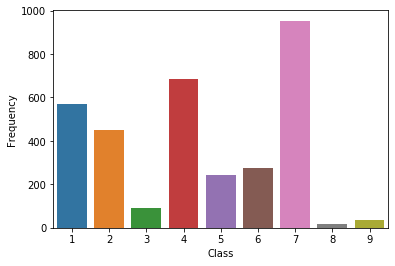

In [7]:
ax = sns.countplot(x='Class', data=train_variants)

ax.set(ylabel = 'Frequency');

Some classes might not predict very well due to their sample size particularly <b>3, 8, 9</b>.

### 1.5 Genes associated with each class

class 1 : TP53 ( 83 counts)
class 2 : EGFR ( 45 counts)
class 3 : BRCA1 ( 15 counts)
class 4 : PTEN ( 115 counts)
class 5 : BRCA1 ( 90 counts)
class 6 : BRCA2 ( 84 counts)
class 7 : EGFR ( 84 counts)
class 8 : BCOR ( 4 counts)
class 9 : SF3B1 ( 15 counts)


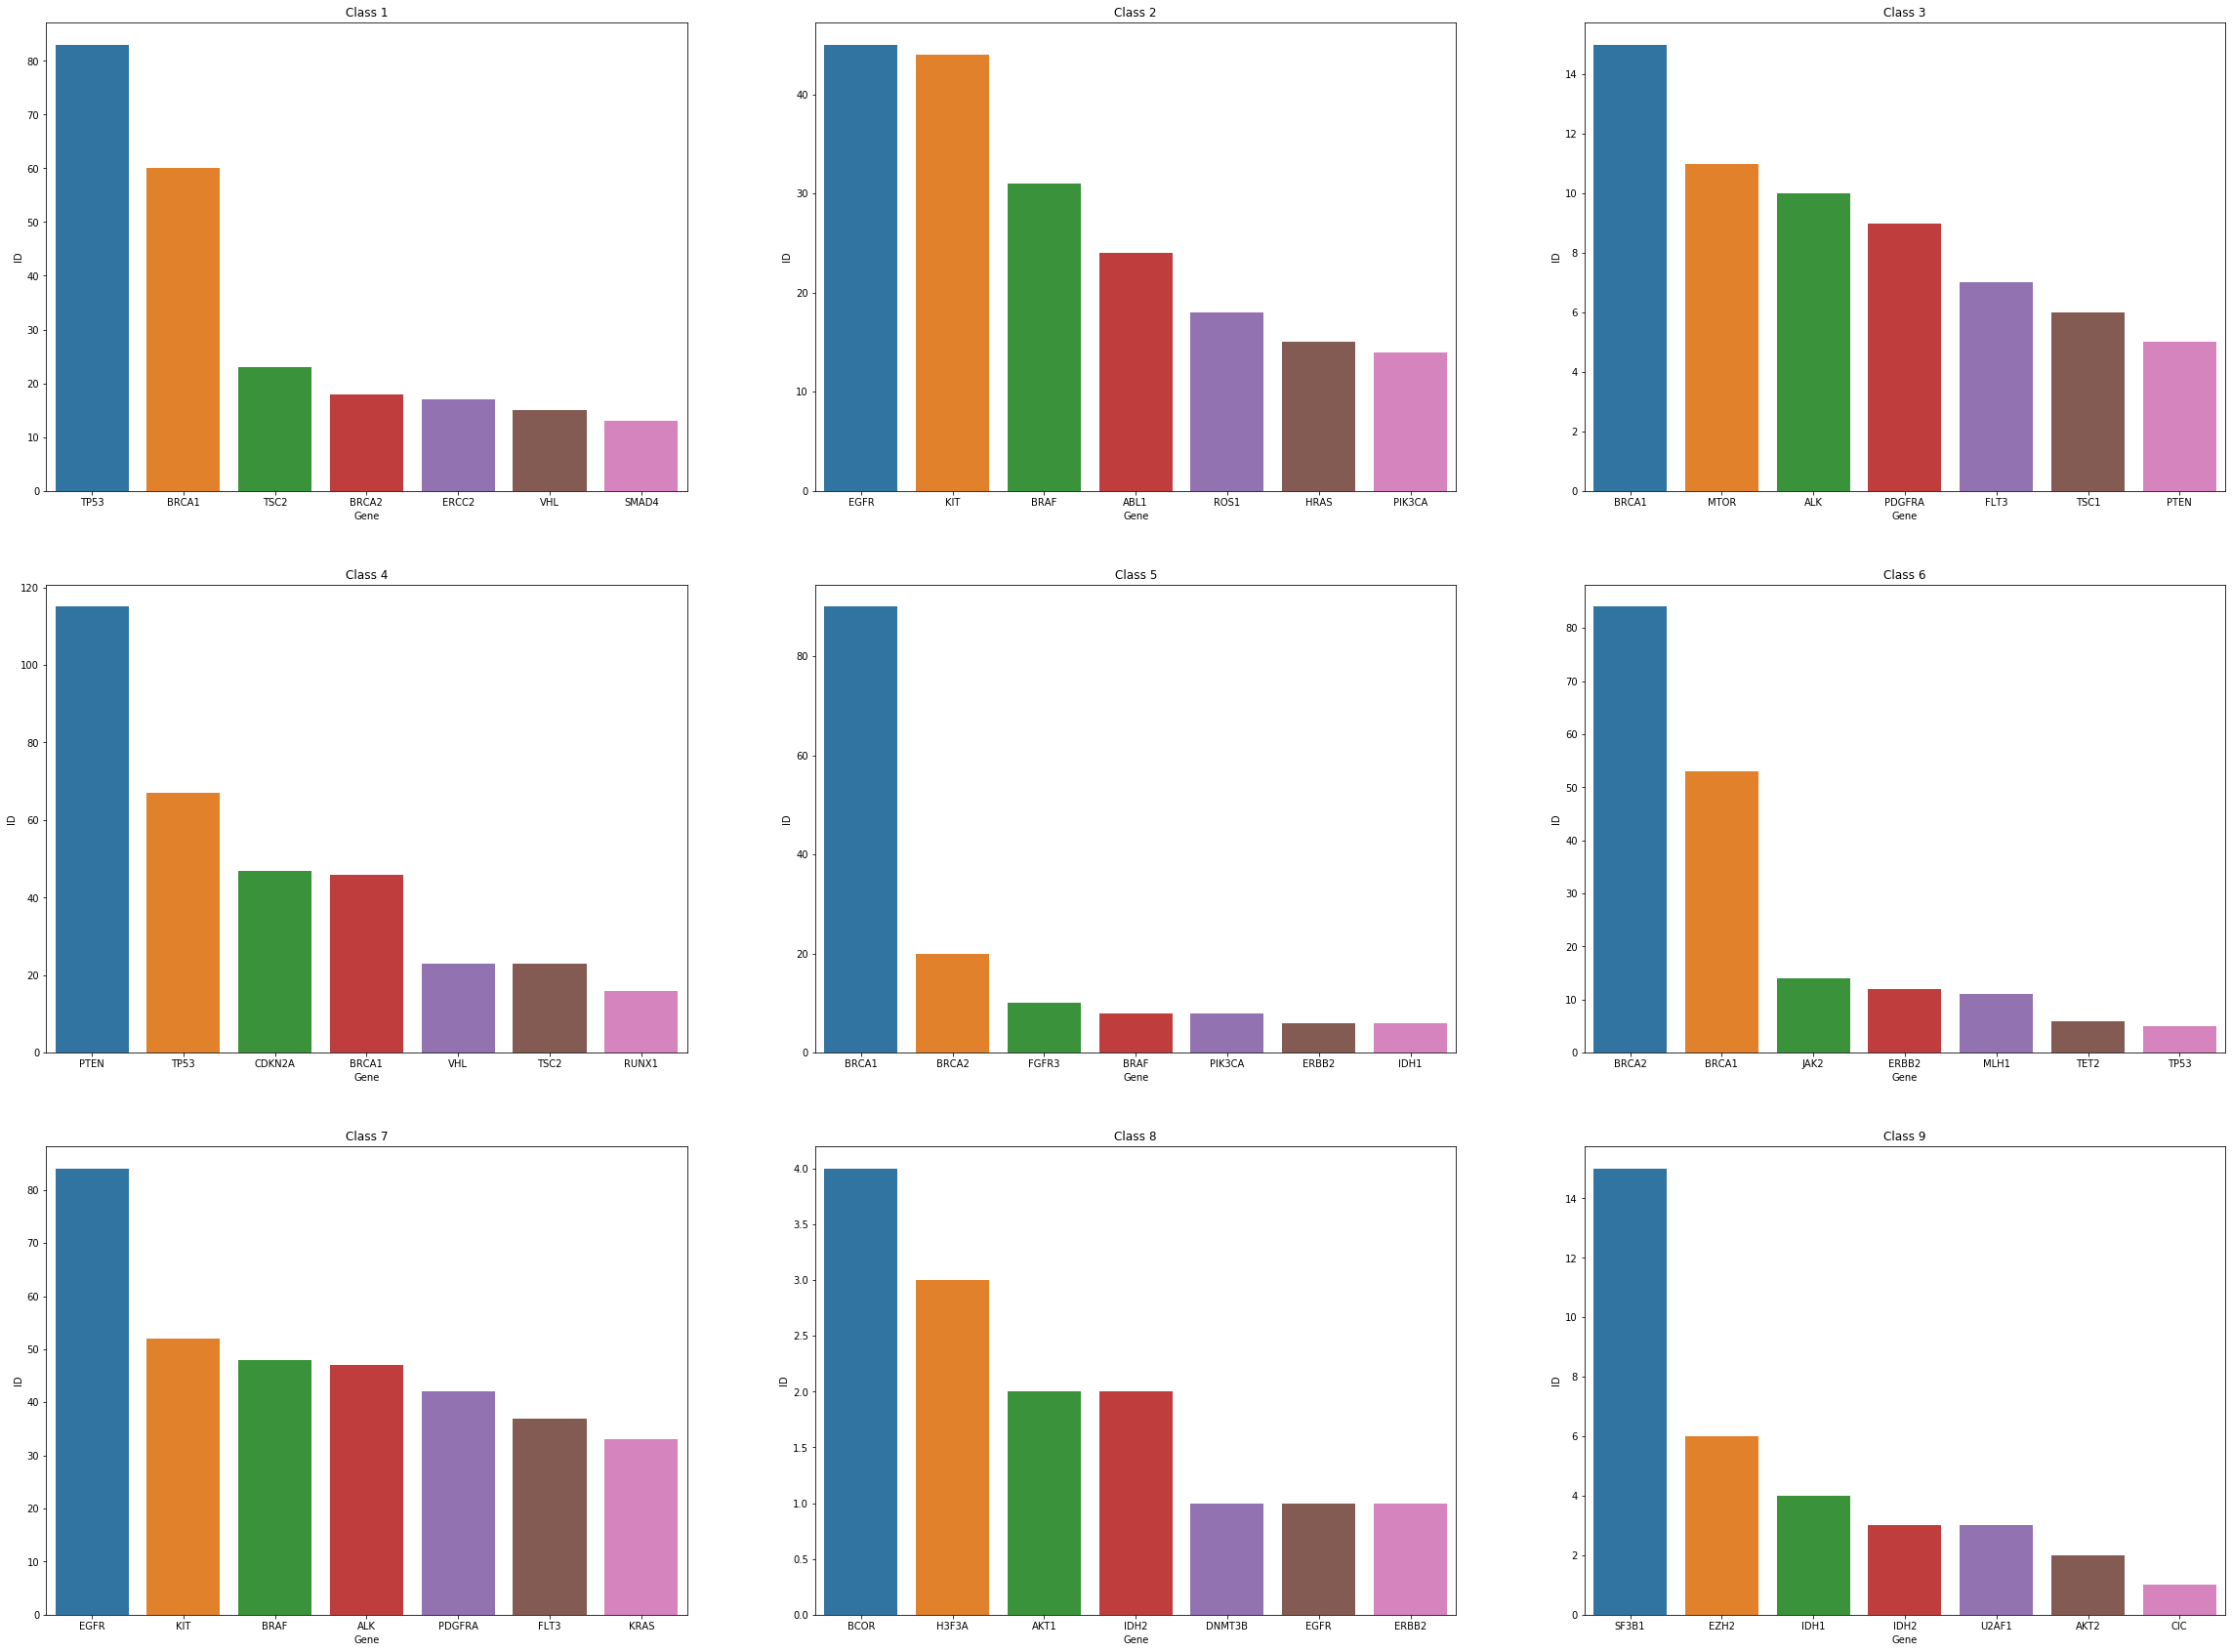

In [8]:
_, axs = plt.subplots(ncols=3, nrows=3, figsize=(40,30))
k = 0
#print('Most frequently associated genes')
for i in range(3):#train_variants['Class'].unique():
    for j in range(3):
        k += 1
        gene_count_grp = train_variants[train_variants['Class']==(k)].groupby('Gene')['ID'].count().reset_index()
        sorted_grp = gene_count_grp.sort_values('ID', ascending=False)[:7]
        high_gene = sorted_grp['Gene'].iloc[0]
        high_frq = sorted_grp['ID'].iloc[0]
        print('class', (k) , ':' , high_gene, '(', high_frq, 'counts)')
        title_name = 'Class '+ str(k)
        sns.barplot(x='Gene', y='ID', data=sorted_grp, ax=axs[i][j]).set_title(title_name);#axs[i-1]

### 1.6 loading 'training_text'

In [9]:
training_text_df = pd.read_csv('msk_dataset/training_text', sep="\|\|", engine='python', header=None, skiprows=1, names=['ID','Text'])
test_text_df = pd.read_csv('msk_dataset/test_text', sep="\|\|", engine='python', header=None, skiprows=1, names=['ID','Text'])
#these arguments are needed as the file is basically a long list of characters

In [10]:
training_text_df['Text'][0]

"Cyclin-dependent kinases (CDKs) regulate a variety of fundamental cellular processes. CDK10 stands out as one of the last orphan CDKs for which no activating cyclin has been identified and no kinase activity revealed. Previous work has shown that CDK10 silencing increases ETS2 (v-ets erythroblastosis virus E26 oncogene homolog 2)-driven activation of the MAPK pathway, which confers tamoxifen resistance to breast cancer cells. The precise mechanisms by which CDK10 modulates ETS2 activity, and more generally the functions of CDK10, remain elusive. Here we demonstrate that CDK10 is a cyclin-dependent kinase by identifying cyclin M as an activating cyclin. Cyclin M, an orphan cyclin, is the product of FAM58A, whose mutations cause STAR syndrome, a human developmental anomaly whose features include toe syndactyly, telecanthus, and anogenital and renal malformations. We show that STAR syndrome-associated cyclin M mutants are unable to interact with CDK10. Cyclin M silencing phenocopies CDK1

This is very informative, but nobody has time for these!

But still, let's further look into this

In [11]:
training_text_df.head(10)

,ID,Text
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...
5,5,Oncogenic mutations in the monomeric Casitas B...
6,6,Oncogenic mutations in the monomeric Casitas B...
7,7,CBL is a negative regulator of activated recep...
8,8,Abstract Juvenile myelomonocytic leukemia (JM...
9,9,Abstract Juvenile myelomonocytic leukemia (JM...


It seems like some elements are repeating.

In [12]:
len(training_text_df['Text'].unique())

1921

### 1.7 Unique Text feature associated with each class

Let's see which genotypes (Text) are most frequently associated with each class

In [13]:
#training_text_only_df = training_text_df['Text']
for i in training_text_df['ID']:
    train_variants.at[i, 'Text'] = training_text_df['Text'][i] #.at is A LOT FASTER than ix/loc/iloc
    train_variants.at[i, 'Text_length'] = len(str(training_text_df['Text'][i]))

train_variants.head(10)
#len(train_variants['ID'])

,ID,Gene,Variation,Class,Text,Text_length
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...,39714.0
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...,36787.0
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...,36787.0
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...,36284.0
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...,41338.0
5,5,CBL,V391I,4,Oncogenic mutations in the monomeric Casitas B...,41338.0
6,6,CBL,V430M,5,Oncogenic mutations in the monomeric Casitas B...,41338.0
7,7,CBL,Deletion,1,CBL is a negative regulator of activated recep...,99044.0
8,8,CBL,Y371H,4,Abstract Juvenile myelomonocytic leukemia (JM...,79873.0
9,9,CBL,C384R,4,Abstract Juvenile myelomonocytic leukemia (JM...,38534.0


In [14]:
#print('Most frequently associated genotypes' + '\n')
for i in train_variants['Class'].unique():
    
    gene_count_grp = train_variants[train_variants['Class']==i].groupby('Text')['ID'].count().reset_index()
    sorted_grp = gene_count_grp.sort_values('ID', ascending=False)[:7]
    for j in range(3):
        high_gene = sorted_grp['Text'].iloc[j]
        high_frq = sorted_grp['ID'].iloc[j]
        print('class', i , ':' , high_gene[:30] + '...', '(', high_frq, 'counts)')
    print('')

class 1 : Tuberous sclerosis complex (TS... ( 16 counts)
class 1 : Genetic screening of the breas... ( 15 counts)
class 1 : The increasing application of ... ( 10 counts)

class 2 :  Abstract  Mutations in the Bc... ( 11 counts)
class 2 : Since Notch phenotypes in Dros... ( 7 counts)
class 2 : Hypoxia inducible factors (HIF... ( 6 counts)

class 3 : Genes encoding components of t... ( 10 counts)
class 3 : In the era of personalized med... ( 7 counts)
class 3 : Mutations in the juxtamembrane... ( 7 counts)

class 4 : The PTEN (phosphatase and tens... ( 49 counts)
class 4 : The tumor suppressor gene PTEN... ( 24 counts)
class 4 : Tuberous sclerosis complex (TS... ( 13 counts)

class 5 : Mutations in BRCA1 and BRCA2 a... ( 35 counts)
class 5 : Genetic screening of the breas... ( 15 counts)
class 5 : Frequent genetic alterations d... ( 9 counts)

class 6 : Mutation screening of the brea... ( 47 counts)
class 6 : Germline mutations of the brea... ( 28 counts)
class 6 : Twenty percent of ind

This is great because certain texts are uniquely associated with each class!

Before we feed this into a machine learning algorithm, let's see how many missing observations we have in our dataset

### 1.8 Check for invalid values

In [15]:
train_variants.describe()

,ID,Class,Text_length
count,3321.000000,3321.000000,3321.000000
mean,1660.000000,4.365854,63754.173141
std,958.834449,2.309781,52293.405846
min,0.000000,1.000000,3.000000
25%,830.000000,2.000000,31355.000000
50%,1660.000000,4.000000,46248.000000
75%,2490.000000,7.000000,80303.000000
max,3320.000000,9.000000,524532.000000


In [16]:
train_variants[train_variants['Text_length']<500]

,ID,Gene,Variation,Class,Text,Text_length
1109,1109,FANCA,S1088F,1,NaN,3.0
1277,1277,ARID5B,Truncating Mutations,1,NaN,3.0
1407,1407,FGFR3,K508M,6,NaN,3.0
1613,1613,VHL,L158Q,4,The case of a 40-year-old woman with severe ed...,337.0
1639,1639,FLT1,Amplification,6,NaN,3.0
2755,2755,BRAF,G596C,7,NaN,3.0


It seems like the missing observation is labeled as "NaN", so let's calculate the proportion of mission observations

In [17]:
print(len(train_variants[train_variants['Text_length']==3])/len(train_variants['Text_length'])*100, '%')

0.15055706112616682 %


### 1.9 Drop invalid values

In [18]:
train_variants = train_variants.dropna()

print(len(train_variants[train_variants['Text_length']==3])/len(train_variants['Text_length'])*100, '%')

0.0 %


## 2. Predicting classes based on given features

### 2.1 Assign unique numerical identifiers to each feature

#### 2.1.1 Building dictionary for each feature

In [19]:
gene_dic = {}
variation_dic = {}
text_dic = {}

for j in train_variants['ID']:
    
    i = j - 0
    
    if train_variants['Gene'].loc[i] not in variation_dic:
        gene_dic.update({train_variants['Gene'].loc[i]: i})

    if train_variants['Variation'].loc[i] not in variation_dic:
        variation_dic.update({train_variants['Variation'].loc[i]: i})
        
    if train_variants['Text'].loc[i] not in text_dic:
        text_dic.update({train_variants['Text'].loc[i]: i})

#### 2.1.2 Create new columns for the identifiers

In [20]:
for i in train_variants['ID']:
    train_variants.at[i, 'GeneQ'] = gene_dic.get(train_variants['Gene'].loc[i])
    train_variants.at[i, 'VariationQ'] = variation_dic.get(train_variants['Variation'].loc[i])
    train_variants.at[i, 'TextQ'] = text_dic.get(train_variants['Text'].loc[i])

### 2.2 Normalize the dataset using MinMaxScaler

In [21]:
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler()

#normalizing only the last three columns of the train_variants
nrml_train_variants = min_max_scaler.fit_transform(train_variants.iloc[:,6:9])

In [22]:
nrml_train_variants

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [7.53012048e-03, 3.01204819e-04, 3.01295571e-04],
       [7.53012048e-03, 6.02409639e-04, 3.01295571e-04],
       ...,
       [1.00000000e+00, 8.49397590e-02, 9.99698704e-01],
       [1.00000000e+00, 9.99698795e-01, 1.00000000e+00],
       [1.00000000e+00, 1.00000000e+00, 9.94275384e-01]])

Before the MinMaxScaler, the array was normalized by root mean square which gave me a poorer result

In [23]:
#nrml_train_variants_textl = train_variants['Text_length'] / np.sqrt(np.sum(train_variants['Text_length']**2))
#nrml_train_variants_class = train_variants['Class'] / np.sqrt(np.sum(train_variants['Class']**2))

### 2.3 Define functions for ML algorithms

#### 2.3.1 Import modules

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score

#### 2.3.2 Function for LinearSVC

In [25]:
def optimized_LinearSVC(X, y, tsize):
    x_ax = []
    max_val = []
    max_acc = []
    max_tsize = []
    max_c = []
    list_dc = {}
    j = 0
    #max_tsize = 1
    #max_rnd = 1
    count = 15
    trange = 10
    for _ in range(count):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=tsize)
        for i in range(1,trange):
            #for j in range(1,rnd):

                svc=LinearSVC(max_iter=1000, C=i/1000)
                SVC_model=svc.fit(X_train , y_train)
                svc_score=SVC_model.score(X_test , y_test)
                #if max_val < svc_score:
                #    max_val, max_tsize, max_rnd = svc_score, i, j
                max_val.append(svc_score)
                max_tsize.append(i/1000)
                if i % 100 == 0:
                    print(trange-i, 'iteration(s) left')

        max_acc.append(np.mean(max_val))
        max_c.append(np.mean(max_tsize))
        max_val = []
        max_tsize = []
        #print('Accuracy:', max_val, '\n'
        #  'Optimal C value:', max_tsize/1000)
    
    list_dc = {'Accuracy': max_acc, 'Optimal C': max_c}
        
    tb_max = pd.DataFrame(data=list_dc)
    
    print(tb_max.head(len(max_acc)))
    
    print('\nMean Accuracy over', count, 'iterations:', np.mean(max_acc),
         '\nMean optimal C over', count, 'iterations:', np.mean(max_c)
         
         )

#### 2.3.3 Function for KNN

In [26]:
def KNN_predict(X, y, tsize, lst_val, subset):
    
    cv_val = 10
    y_list = 0
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=tsize)
    y_test_dp = y_test[y_test!=0].dropna()
    #x_test_dp = X_test[X_test!=0].dropna()
    neigh = KNeighborsClassifier(n_neighbors=9)
    neigh.fit(X_train,y_train)
    y_pred = neigh.predict(X_test)
    scores = cross_validate(neigh, X_train, y_train, cv=cv_val)
    
    if lst_val:
        print('Accuracy without CV:', accuracy_score(y_test, y_pred),
         '\nAccuracy after', cv_val,'CV:', scores['test_score'].mean())
            
        np.set_printoptions(threshold=2000)
        df_cs = np.column_stack((y_test, y_pred))
        y_test.count()
        print(df_cs)
        #print(np.column_stack((y_test, y_pred)))
    if subset:
        for i in range(1,10):
            for j in range(len(y_test)):
                if y_test[y_test.index[j]]==i and y_test[y_test.index[j]] == y_pred[j]:
                    y_list += 1
            print('Class #', i, '\nCorrect #:', y_list, '\nTotal #:', len(y_test[y_test==i]), 
                  '\nAccuracy:', y_list/len(y_test[y_test==i]), '\n')
            y_list = 0

    return scores['test_score'].mean()

### 2.4 Single feature performance comparison

#### 2.4.1 Comparison by LinearSVC

In [27]:
for i in range(3):
    print(train_variants.columns[i+1])
    optimized_LinearSVC(nrml_train_variants[:,i].reshape(-1,1), train_variants['Class'], 0.3)
    print('\n')

Gene
    Accuracy  Optimal C
0   0.285204      0.005
1   0.292239      0.005
2   0.286879      0.005
3   0.287884      0.005
4   0.261307      0.005
5   0.300838      0.005
6   0.278392      0.005
7   0.288666      0.005
8   0.269347      0.005
9   0.285315      0.005
10  0.306644      0.005
11  0.287661      0.005
12  0.287326      0.005
13  0.297934      0.005
14  0.298157      0.005

Mean Accuracy over 15 iterations: 0.28758607854085244 
Mean optimal C over 15 iterations: 0.005


Variation
    Accuracy  Optimal C
0   0.304969      0.005
1   0.311446      0.005
2   0.283194      0.005
3   0.304746      0.005
4   0.296259      0.005
5   0.298269      0.005
6   0.304411      0.005
7   0.295254      0.005
8   0.324065      0.005
9   0.309994      0.005
10  0.284534      0.005
11  0.295924      0.005
12  0.308989      0.005
13  0.285315      0.005
14  0.287326      0.005

Mean Accuracy over 15 iterations: 0.2996463800483901 
Mean optimal C over 15 iterations: 0.005


Class
    Accuracy  

#### 2.4.2 Comparison by KNN

In [28]:
#y_ax = pd.DataFrame()
y_ID= []
y_feature = []
y_score = []
y_hue = []

for j in range(3):
    #y_score = []
    for i in range(1,10):
        #y_ax['ID'].iloc[i] = i
        y_ID.append(i/10)
        y_score.append(KNN_predict(nrml_train_variants[:,j].reshape(-1,1), train_variants['Class'], i/10, False, False));
        if j == 0:
            y_hue.append('Gene')
        elif j == 1:
            y_hue.append('Variations')
        elif j == 2:
            y_hue.append('Text')
    #y_feature.append(y_score)
    #y_ax['Score'].append(KNN_predict(nrml_train_variants[:,0].reshape(-1,1), train_variants['Class'], i/10, False))
    
y_ax = pd.DataFrame({'Test Size': y_ID, 'Score': y_score, 'Feature': y_hue},
                   index = y_ID)

C:\Users\jongm\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 9 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\jongm\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 8 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\jongm\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 9 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\jongm\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 2 members, which is too few. The

C:\Users\jongm\Anaconda3\lib\site-packages\pandas\core\indexes\base.py:3078: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(key)


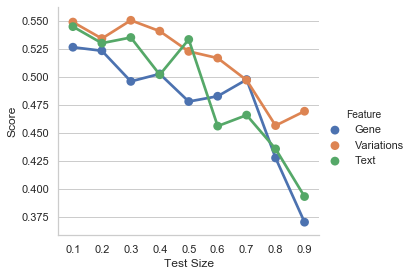

In [29]:
sns.set(style='whitegrid')
sns.catplot(data=y_ax, x='Test Size', y='Score', aspect=1.2, height=4, hue='Feature', kind='point');

### 2.5 Multiple feature performance comparison

#### 2.5.1 Comparison by LinearSVC

In [30]:
optimized_LinearSVC(nrml_train_variants, train_variants['Class'], 0.3)

    Accuracy  Optimal C
0   0.310776      0.005
1   0.321608      0.005
2   0.270352      0.005
3   0.292016      0.005
4   0.290117      0.005
5   0.282077      0.005
6   0.302178      0.005
7   0.294807      0.005
8   0.294249      0.005
9   0.318481      0.005
10  0.255276      0.005
11  0.342267      0.005
12  0.294696      0.005
13  0.295924      0.005
14  0.296371      0.005

Mean Accuracy over 15 iterations: 0.2974129908803276 
Mean optimal C over 15 iterations: 0.005


#### 2.5.2 Comparison by KNN

In [31]:
KNN_predict(nrml_train_variants, train_variants['Class'], 0.3, True, False)

Accuracy without CV: 0.549748743718593 
Accuracy after 10 CV: 0.5358375994316968
[[6 6]
 [5 7]
 [7 7]
 [7 7]
 [7 4]
 [4 1]
 [1 1]
 [6 6]
 [1 1]
 [7 7]
 [4 7]
 [2 7]
 [3 7]
 [3 7]
 [6 6]
 [5 2]
 [2 2]
 [6 1]
 [7 7]
 [4 5]
 [5 6]
 [5 7]
 [4 4]
 [4 4]
 [7 4]
 [2 7]
 [7 6]
 [1 5]
 [4 4]
 [2 1]
 [7 7]
 [7 7]
 [4 4]
 [4 2]
 [6 6]
 [1 1]
 [2 2]
 [6 5]
 [5 5]
 [7 7]
 [1 7]
 [7 7]
 [2 7]
 [4 1]
 [4 4]
 [1 1]
 [7 7]
 [1 1]
 [7 7]
 [9 9]
 [7 7]
 [7 7]
 [7 7]
 [1 1]
 [7 2]
 [3 4]
 [2 7]
 [4 4]
 [2 4]
 [1 5]
 [5 7]
 [6 1]
 [1 1]
 [7 7]
 [7 4]
 [4 4]
 [2 2]
 [7 7]
 [5 7]
 [7 7]
 [9 9]
 [5 7]
 [9 1]
 [1 4]
 [4 7]
 [1 5]
 [7 7]
 [7 4]
 [7 2]
 [4 2]
 [7 7]
 [6 5]
 [4 4]
 [5 5]
 [4 4]
 [7 7]
 [2 1]
 [7 1]
 [7 7]
 [1 1]
 [4 4]
 [7 2]
 [6 6]
 [6 7]
 [7 2]
 [1 1]
 [4 4]
 [6 4]
 [1 1]
 [7 5]
 [2 2]
 [4 4]
 [4 4]
 [7 2]
 [2 4]
 [2 7]
 [9 2]
 [2 7]
 [7 2]
 [2 2]
 [4 4]
 [4 4]
 [1 7]
 [1 4]
 [7 2]
 [5 1]
 [1 4]
 [2 7]
 [7 7]
 [4 4]
 [2 7]
 [6 7]
 [4 4]
 [1 4]
 [7 7]
 [1 4]
 [6 6]
 [1 7]
 [1 1]
 [4 5]
 [4 4]
 [

0.5358375994316968

In [32]:
KNN_predict(nrml_train_variants, train_variants['Class'], 0.3, False, True)

Class # 1 
Correct #: 87 
Total #: 184 
Accuracy: 0.47282608695652173 

Class # 2 
Correct #: 39 
Total #: 135 
Accuracy: 0.28888888888888886 

Class # 3 
Correct #: 2 
Total #: 27 
Accuracy: 0.07407407407407407 

Class # 4 
Correct #: 131 
Total #: 207 
Accuracy: 0.6328502415458938 

Class # 5 
Correct #: 12 
Total #: 69 
Accuracy: 0.17391304347826086 

Class # 6 
Correct #: 38 
Total #: 69 
Accuracy: 0.5507246376811594 

Class # 7 
Correct #: 207 
Total #: 286 
Accuracy: 0.7237762237762237 

Class # 8 
Correct #: 0 
Total #: 8 
Accuracy: 0.0 

Class # 9 
Correct #: 5 
Total #: 10 
Accuracy: 0.5 



0.5403895444493676

### 3. Conclusions

* Three features were fed into classification ML algorithms: LinearSCV and KNN
* Accuracy of prediction did not vary much by each feature
* Low accuracy score is partly attributed to low sample size for certain classes
* Performance may improve if each class is associated with more distinctive features

### Future directions

* Predict by NLP algorithms
* Apply these classfication algorithms on my actual research data which involves prediction of clinical features by antibody profiles of HIV patients
* Do more Keggle competitions!

### References

https://www.kaggle.com/dextrousjinx/brief-insight-on-genetic-variations<br>
https://www.kaggle.com/bhuvaneshwaran/redefining-cancer-treatment-linear-svc/notebook